In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import erfc
from scipy import integrate

In [103]:
μReLU = [0.398942, 
         0.5, 
         0.398942, 
         0., 
         -0.398942, 
         0.]
Eσ2ReLU = .5

μELU = [0.1605205722667549, 
        0.7615782918644975, 
        0.26157829186526865,
        -0.1373639885354897,
        -0.1373639885357776,
        0.2615782918541118]
Eσ2ELU = 0.6449454174923381

CC0 = "#0d3c55"
CC1 = "#c02e1d"
CC2 = "#ef8b2c"
CC3 = "#a2b86c"
CC4 = "#117899"

def G(z,ηℓ):
    """
    Stieltjes transformation of the MP distribution with ratio ηℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    ηℓ: double
        ratio of the MP distribution
    """
    if(z<0):
        res = (1 - z - ηℓ - np.sqrt((1- z - ηℓ)**2 - 4*ηℓ*z))/(2*z*ηℓ)
    else:
        res = 0
    return res

def dG(z,ηℓ):
    """
    Derivative of the Stieltjes transformation of the MP distribution with ratio ηℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    ηℓ: double
        ratio of the MP distribution
    """
    if(z<0):
        res = (-z*(1 + ηℓ) + (ηℓ - 1)*(-1 + ηℓ + np.sqrt((z - 1)**2 - 2*(1 + z)*ηℓ + ηℓ**2)))/(2*ηℓ*z**2*np.sqrt(-4*ηℓ + (1 - z + ηℓ)**2))
    else:
        res = 0
    return res

def H(x):
    return erfc(-x/np.sqrt(2))/2

def Hnum(x):
    if(x>5) :
        return 1
    if(x<-5) :
        return 0
    else :
        return erfc(-x/np.sqrt(2))/2

def saddle(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs
    
    Parameters:
    -----------
    N : int
        number of random features
    P : int
        size of the training set
    L : int
        truncation of the activation function
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           integration rate
    """
    if(step==1): # random initial conditions
        hχ_old = 5*np.random.rand(L)
        hq_old = 5*np.random.rand(L)
        hχ0_old, hq0_old= 5*np.random.rand(2)
        hm_old = 5*np.random.rand(L)
    else :
        hχ_old,hq_old,hm_old,hχ0_old,hq0_old,χ_old,q_old,m_old,χ0_old,q0_old,m0_old,χStar,qStar,mStar,tStar= saddle(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
    
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    η = np.array([N/math.comb(D,l) for l in range(1,L+1)])
    γ = η*np.reciprocal(hχ_old)*(ζ + hχ0_old)
    
    χ = np.array([η[l]*(1 - γ[l]*G(-γ[l],η[l]))/hχ_old[l] for l in range(0,L)])
    χ0 = (1 - np.array([1 - γ[l]*G(-γ[l],η[l]) for l in range(0,L)]).sum())/(hχ0_old+ζ)
    q = np.array([η[l]*hq0_old/((ζ + hχ0_old)*hχ_old[l])*(γ[l]*G(-γ[l],η[l]) - γ[l]**2*dG(-γ[l],η[l])) + η[l]*(hm_old[l]**2 + hq_old[l])/(hχ_old[l]**2)*(1 + γ[l]**2*dG(-γ[l],η[l]) - 2*γ[l]*G(-γ[l],η[l])) for l in range(0,L)])
    q0 = hq0_old/(ζ + hχ0_old)**2*(1 - np.array([1 - γ[l]**2*dG(-γ[l],η[l]) for l in range(0,L)]).sum())  + np.array([(hm_old[l]**2 + hq_old[l])/(hχ_old[l]*(ζ+hχ0_old))*(γ[l]*G(-γ[l],η[l]) - γ[l]**2*dG(-γ[l],η[l])) for l in range(0,L)]).sum()
    m = χ*hm_old
    m0 = y/μ0
    
    χStar = μPerp**2*χ0 + np.array([χ[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    qStar = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    mStar = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    tStar = y
    
    hχ = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/(np.math.factorial(l+1)*(1+χStar)) for l in range(0,L)]) ) + (1-rate)*hχ_old
    hχ0 = rate*(P/N*μPerp**2/(1+χStar)) + (1-rate)*hχ0_old
    hq = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/np.math.factorial(l+1)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2 for l in range(0,L)]) ) + (1-rate)*hq_old
    hq0 = rate*(P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2) + (1-rate)*hq0_old
    hm = rate*(np.array([P/math.comb(D,l+1)*μ[l]*τ[l+1]/np.sqrt(np.math.factorial(l+1))*yν/(1+χStar) for l in range(0,L)])) + (1-rate)*hm_old
        
    return hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar

def saddleAsymptI(P,K,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs, asymptotic limit N > P
    
    Parameters:
    -----------
    P : int
        size of the training set
    K : int
        order of log P / log D
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           integration rate
    """
    if(step==1): # random initial conditions
        hχK_old,hqK_old,hmK_old = 5*np.random.rand(3)
    else :
        hχ_old,hq_old,hm_old,hχ0_old,hq0_old,χ_old,q_old,m_old,χ0_old,q0_old,m0_old,χStar,qStar,mStar,tStar = saddleAsymptI(P,K,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
        hmK_old = hm_old[-1]
        hqK_old = hq_old[-1]
        hχK_old = hχ_old[-1]
        
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,K)]).sum())
    
    χK = 1/(hχK_old + ζ)
    χ = np.zeros(K-1)
    χ = np.append(χ,χK)
    χ0 = 1/ζ
    qK = (hmK_old**2 + hqK_old)/(hχK_old + ζ)**2
    q = np.array([np.math.factorial(l+1)*τ[l+1]**2/(μ[l]**2)*yν**2 for l in range(0,K-1)])
    q = np.append(q,qK)
    q0 = 0
    mK = np.sqrt(np.math.factorial(K))*τ[K]/μ[K-1]*yν*(1-ζ*χK)
    m = np.array([np.sqrt(np.math.factorial(l+1))*τ[l+1]/μ[l]*yν for l in range(0,K-1)])
    m = np.append(m,mK)
    m0 = y/μ0
    
    χStar = μPerp**2*χ0 + np.array([χ[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,K)]).sum()
    qStar = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,K)]).sum()
    mStar = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,K)]).sum()
    tStar = y
    
    hχK = rate*(P/(math.comb(D,K)*np.math.factorial(K))*μ[K-1]**2/(1+χStar) ) + (1 - rate)*hχK_old
    hχ = np.full(K-1,np.inf)
    hχ = np.append(hχ,hχK)
    hχ0 = 0
    hqK = rate*( P/math.comb(D,K)*μ[K-1]**2/np.math.factorial(K)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2) + (1-rate)*hqK_old
    hq = np.full(K-1,np.inf)
    hq = np.append(hq,hqK)
    hq0 = 0
    hmK = rate*(P/math.comb(D,K)*μ[K-1]*τ[K]/np.sqrt(np.math.factorial(K))*yν/(1+χStar)) + (1-rate)*hmK_old
    hm = np.full(K-1,np.inf)
    hm = np.append(hm,hmK)
    
    return hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar


def saddleAsymptII(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs, asymptotic limit N ~ P
    
    Parameters:
    -----------
    N : int
        number of random features
    P : int
        size of the training set
    L : int
        truncation of the activation function
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hq0_old,hχ0_old,hmL_old,hqL_old,hχL_old = 10*np.random.rand(5)
    else :
        hχ_old,hq_old,hm_old,hχ0_old,hq0_old,χ_old,q_old,m_old,χ0_old,q0_old,m0_old,χStar,qStar,mStar,tStar = saddleAsymptII(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
        hmL_old = hm_old[-1]
        hqL_old = hq_old[-1]
        hχL_old = hχ_old[-1]
        
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    ηL = N/math.comb(D,L)
    γL = ηL/(hχL_old)*(ζ + hχ0_old)
    
    χL = ηL*(1 - γL*G(-γL,ηL))/hχL_old
    χ = np.zeros(L-1)
    χ = np.append(χ,χL)
    χ0 = γL*G(-γL,ηL)/(hχ0_old + ζ)
    qL = ηL*(hq0_old)/((ζ + hχ0_old)*hχL_old)*(γL*G(-γL,ηL)  - γL**2*dG(-γL,ηL)) + ηL*(hmL_old**2 + hqL_old)/(hχL_old**2)*(1 + γL**2*dG(-γL,ηL) - 2*γL*G(-γL,ηL) )
    q = np.array([np.math.factorial(l+1)*τ[l+1]**2/(μ[l]**2)*yν**2 for l in range(0,L-1)])
    q = np.append(q,qL)
    q0 = (hq0_old)/((ζ + hχ0_old)**2 )*γL**2*dG(-γL,ηL) + (hmL_old**2 + hqL_old)/(hχL_old*(hχ0_old+ζ))*( γL*G(-γL,ηL) - γL**2*dG(-γL,ηL))
    mL = χL*hmL_old
    m = np.array([np.sqrt(np.math.factorial(l+1))*τ[l+1]/μ[l]*yν for l in range(0,L-1)])
    m = np.append(m,mL)
    m0 = y/μ0
    
    χStar = μPerp**2*χ0 + np.array([χ[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    qStar = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    mStar = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    tStar = y
    
    hχL = rate*(P/(math.comb(D,L)*np.math.factorial(L))*μ[L-1]**2/(1+χStar) ) + (1 - rate)*hχL_old
    hχ = np.full(L-1,np.inf)
    hχ = np.append(hχ,hχL)
    hχ0 = rate*(P/N*μPerp**2/(1+χStar)) + (1 - rate)*hχ0_old
    hqL = rate*(P/math.comb(D,L)*μ[L-1]**2/np.math.factorial(L)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar  )/(1+χStar)**2) + (1-rate)*hqL_old
    hq = np.full(L-1,np.inf)
    hq = np.append(hq,hqL)
    hq0 = rate*(P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*mStar + qStar)/(1+χStar)**2) + (1-rate)*hq0_old
    hmL = rate*(P/math.comb(D,L)*μ[L-1]*τ[L]/np.sqrt(np.math.factorial(L))*yν/(1+χStar)) + (1-rate)*hmL_old
    hm = np.full(L-1,np.inf)
    hm = np.append(hm,hmL)
    
    return hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar


def EgClas(mStar,qStar,θ0=0,tStar=0):
    if(θ0==0):
        return 1/math.pi*np.arccos(mStar/np.sqrt(qStar))
    else : # update with the right function
        return 0
    
def EgRegr(mStar,qStar,θ0=0,tStar=0,Δ=0):
    return 1 - 2*mStar + qStar + (tStar - θ0)**2 + Δ 

# Classification task, linear teacher ($\theta^{(0)} = 0$), ELU activation, 
# $D = 30$, $N = 10^4$

In [96]:
C_T1_Th0_Ps = np.logspace(1,5,100)
maxstep = 1000

C_T1_Th0_Egs = list()
C_T1_Th0_EgsAsI1 = list()
C_T1_Th0_EgsAsI2 = list()
C_T1_Th0_EgsAsI3 = list()
C_T1_Th0_EgsAsII = list()
C_T1_Th0_q0s = list()
C_T1_Th0_q1s = list()
C_T1_Th0_q2s = list()
C_T1_Th0_χ0s = list()
C_T1_Th0_χ1s = list()
C_T1_Th0_χ2s = list()
C_T1_Th0_m0s = list()
C_T1_Th0_m1s = list()
C_T1_Th0_m2s = list()
for p in C_T1_Th0_Ps:
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar = saddle(10**4,p,3,np.array([0,1,0,0]),maxstep,rate=.4)
    C_T1_Th0_Egs.append(EgClas(mStar,qStar))
    C_T1_Th0_q0s.append(q0)
    C_T1_Th0_q1s.append(q[0])
    C_T1_Th0_q2s.append(q[1])
    C_T1_Th0_χ0s.append(χ0)
    C_T1_Th0_χ1s.append(χ[0])
    C_T1_Th0_χ2s.append(χ[1])
    C_T1_Th0_m0s.append(m0)
    C_T1_Th0_m1s.append(m[0])
    C_T1_Th0_m2s.append(m[1])
    χStar,qStar,mStar,tStar = saddleAsymptI(p,1,np.array([0,1,0,0]),maxstep,rate=.4)[-4:]
    C_T1_Th0_EgsAsI1.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptI(p,2,np.array([0,1,0,0]),maxstep,rate=.4)[-4:]
    C_T1_Th0_EgsAsI2.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptI(p,3,np.array([0,1,0,0]),maxstep,rate=.4)[-4:]
    C_T1_Th0_EgsAsI3.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptII(10**4,p,3,np.array([0,1,0,0]),maxstep,rate=.4)[-4:]
    C_T1_Th0_EgsAsII.append(EgClas(mStar,qStar))
    

In [97]:
C_T1_Th0_PsNum = pd.read_csv("data/eluDATAzeta8.csv")["P"].tolist()
C_T1_Th0_EgsNum = pd.read_csv("data/eluDATAzeta8.csv")["gen"].tolist()
C_T1_Th0_EgsNumErr = np.array(pd.read_csv("data/eluDATAzeta8.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/eluDATAzeta8.csv")["T"].tolist())))

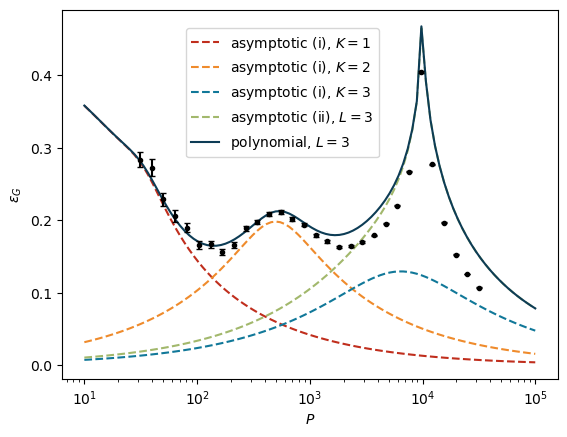

In [117]:
plt.plot(C_T1_Th0_Ps,np.array(C_T1_Th0_EgsAsI1),'--',label=r"asymptotic (i), $K = 1$",color=CC1)
plt.plot(C_T1_Th0_Ps,np.array(C_T1_Th0_EgsAsI2),'--',label=r"asymptotic (i), $K = 2$",color=CC2)
plt.plot(C_T1_Th0_Ps,np.array(C_T1_Th0_EgsAsI3),'--',label=r"asymptotic (i), $K = 3$",color=CC4)
plt.plot(C_T1_Th0_Ps,np.array(C_T1_Th0_EgsAsII),'--',label=r"asymptotic (ii), $L = 3$",color=CC3)
plt.plot(C_T1_Th0_Ps,np.array(C_T1_Th0_Egs),label=r"polynomial, $L=3$",color=CC0)
plt.errorbar(C_T1_Th0_PsNum,C_T1_Th0_EgsNum,yerr=C_T1_Th0_EgsNumErr,fmt='.',color='black',capsize=2)
plt.xscale('log')
plt.xlabel(r'$P$')
plt.ylabel(r'$\epsilon_G$')
plt.legend(loc=(.25,.6))
plt.show()

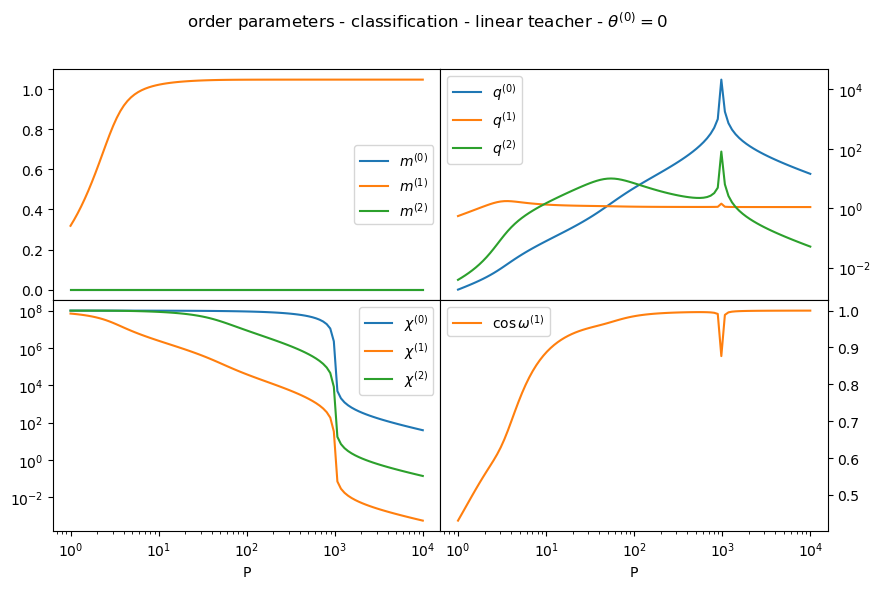

In [136]:
fig,((plM,plQ),(plχ,plCos)) = plt.subplots(nrows=2,ncols=2,figsize=(10,6))
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle(r"order parameters - classification - linear teacher - $\theta^{(0)} = 0$")
plQ.plot(Ps,np.array(C_T1_Th0_q0s),label=r"$q^{(0)}$")
plQ.plot(Ps,np.array(C_T1_Th0_q1s),label=r"$q^{(1)}$")
plQ.plot(Ps,np.array(C_T1_Th0_q2s),label=r"$q^{(2)}$")
plM.plot(Ps,np.array(C_T1_Th0_m0s),label=r"$m^{(0)}$")
plM.plot(Ps,np.array(C_T1_Th0_m1s),label=r"$m^{(1)}$")
plM.plot(Ps,np.array(C_T1_Th0_m2s),label=r"$m^{(2)}$")
plχ.plot(Ps,np.array(C_T1_Th0_χ0s),label=r"$\chi^{(0)}$")
plχ.plot(Ps,np.array(C_T1_Th0_χ1s),label=r"$\chi^{(1)}$")
plχ.plot(Ps,np.array(C_T1_Th0_χ2s),label=r"$\chi^{(2)}$")
plCos.plot(Ps,np.array(C_T1_Th0_m1s)*np.reciprocal(np.sqrt(np.array(C_T1_Th0_q1s))),label=r"$\cos \omega^{(1)}$",color="C1")
plQ.set(xscale='log',yscale='log')
plQ.set_xticks([])
plQ.set_xticks([],minor=True)
plQ.yaxis.tick_right()
plM.set(xscale='log')
plM.set_xticks([])
plM.set_xticks([],minor=True)
plχ.set(xscale='log',yscale='log')
plχ.set_xlabel('P')
plCos.set(xscale='log')
plCos.yaxis.tick_right()
plCos.set_xlabel('P')
plQ.legend()
plM.legend()
plχ.legend()
plCos.legend()

# Classification task, quadratic teacher ($\theta^{(0)} = 0$), ELU activation, 
# $D = 30$, $N = 10^4$

In [62]:
C_T2_Th0_Ps = np.logspace(1,5,100)
maxstep = 1000

C_T2_Th0_Egs = list()
C_T2_Th0_EgsAsI1 = list()
C_T2_Th0_EgsAsI2 = list()
C_T2_Th0_EgsAsI3 = list()
C_T2_Th0_EgsAsII = list()
C_T2_Th0_q0s = list()
C_T2_Th0_q1s = list()
C_T2_Th0_q2s = list()
C_T2_Th0_q3s = list()
C_T2_Th0_χ0s = list()
C_T2_Th0_χ1s = list()
C_T2_Th0_χ2s = list()
C_T2_Th0_χ3s = list()
C_T2_Th0_m0s = list()
C_T2_Th0_m1s = list()
C_T2_Th0_m2s = list()
for p in C_T2_Th0_Ps:
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar = saddle(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep)
    C_T2_Th0_Egs.append(EgClas(mStar,qStar))
    C_T2_Th0_q0s.append(q0)
    C_T2_Th0_q1s.append(q[0])
    C_T2_Th0_q2s.append(q[1])
    C_T2_Th0_q3s.append(q[2])
    C_T2_Th0_χ0s.append(χ0)
    C_T2_Th0_χ1s.append(χ[0])
    C_T2_Th0_χ2s.append(χ[1])
    C_T2_Th0_χ3s.append(χ[2])
    C_T2_Th0_m0s.append(m0)
    C_T2_Th0_m1s.append(m[0])
    C_T2_Th0_m2s.append(m[1])
    χStar,qStar,mStar,tStar = saddleAsymptI(p,1,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-4:]
    C_T2_Th0_EgsAsI1.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptI(p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-4:]
    C_T2_Th0_EgsAsI2.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptI(p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-4:]
    C_T2_Th0_EgsAsI3.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptII(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4)[-4:]
    C_T2_Th0_EgsAsII.append(EgClas(mStar,qStar))

In [63]:
C_T2_Th0_PsNum = pd.read_csv("data/eluDATAzeta8quad.csv")["P"].tolist()
C_T2_Th0_EgsNum = pd.read_csv("data/eluDATAzeta8quad.csv")["gen"].tolist()
C_T2_Th0_EgsNumErr = np.array(pd.read_csv("data/eluDATAzeta8quad.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/eluDATAzeta8quad.csv")["T"].tolist())))

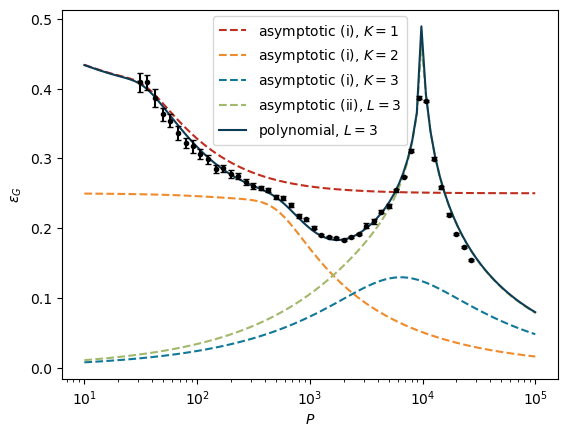

In [134]:
plt.plot(C_T2_Th0_Ps,np.array(C_T2_Th0_EgsAsI1),'--',label=r"asymptotic (i), $K = 1$",color=CC1)
plt.plot(C_T2_Th0_Ps,np.array(C_T2_Th0_EgsAsI2),'--',label=r"asymptotic (i), $K = 2$",color=CC2)
plt.plot(C_T2_Th0_Ps,np.array(C_T2_Th0_EgsAsI3),'--',label=r"asymptotic (i), $K = 3$",color=CC4)
plt.plot(C_T2_Th0_Ps,np.array(C_T2_Th0_EgsAsII),'--',label=r"asymptotic (ii), $L = 3$",color=CC3)
plt.plot(C_T2_Th0_Ps,np.array(C_T2_Th0_Egs),label=r"polynomial, $L=3$",color=CC0)
plt.errorbar(C_T2_Th0_PsNum,C_T2_Th0_EgsNum,yerr=C_T2_Th0_EgsNumErr,fmt='.',color="black",capsize=2)
plt.xscale('log')
plt.xlabel(r'$P$')
plt.ylabel(r'$\epsilon_G$')
plt.legend()
plt.show()

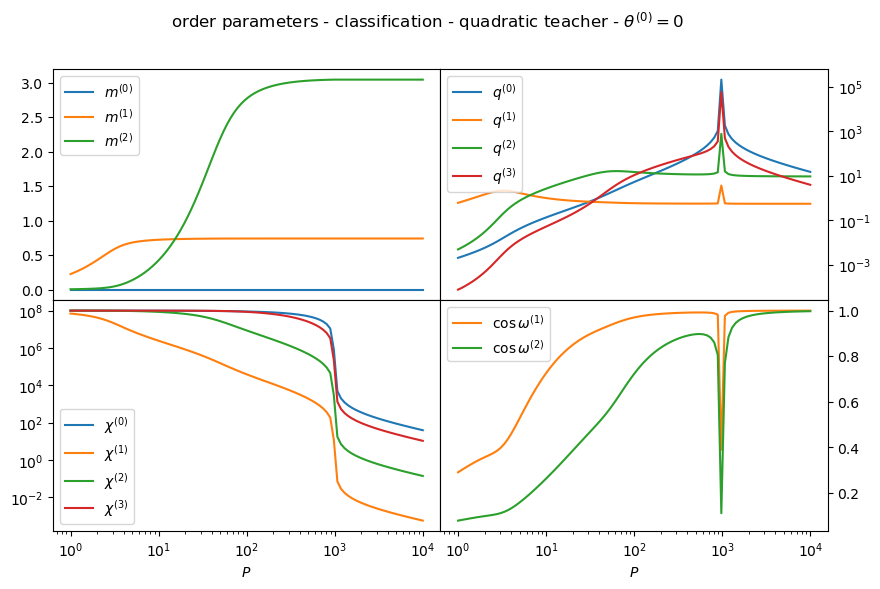

In [135]:
fig,((plM,plQ),(plχ,plCos)) = plt.subplots(nrows=2,ncols=2,figsize=(10,6))
plt.subplots_adjust(hspace=0,wspace=0)
fig.suptitle(r"order parameters - classification - quadratic teacher - $\theta^{(0)} = 0$")
plQ.plot(Ps,np.array(C_T2_Th0_q0s),label=r"$q^{(0)}$")
plQ.plot(Ps,np.array(C_T2_Th0_q1s),label=r"$q^{(1)}$")
plQ.plot(Ps,np.array(C_T2_Th0_q2s),label=r"$q^{(2)}$")
plQ.plot(Ps,np.array(C_T2_Th0_q3s),label=r"$q^{(3)}$")
plM.plot(Ps,np.array(C_T2_Th0_m0s),label=r"$m^{(0)}$")
plM.plot(Ps,np.array(C_T2_Th0_m1s),label=r"$m^{(1)}$")
plM.plot(Ps,np.array(C_T2_Th0_m2s),label=r"$m^{(2)}$")
plCos.plot(Ps,np.array(C_T2_Th0_m1s)*np.reciprocal(np.sqrt(np.array(C_T2_Th0_q1s))),label=r"$\cos \omega^{(1)}$",color="C1")
plCos.plot(Ps,np.array(C_T2_Th0_m2s)*np.reciprocal(np.sqrt(np.array(C_T2_Th0_q2s))),label=r"$\cos \omega^{(2)}$",color="C2")
plχ.plot(Ps,np.array(C_T2_Th0_χ0s),label=r"$\chi^{(0)}$")
plχ.plot(Ps,np.array(C_T2_Th0_χ1s),label=r"$\chi^{(1)}$")
plχ.plot(Ps,np.array(C_T2_Th0_χ2s),label=r"$\chi^{(2)}$")
plχ.plot(Ps,np.array(C_T2_Th0_χ3s),label=r"$\chi^{(3)}$")
plQ.set(xscale='log',yscale='log')
plQ.set_xticks([])
plQ.set_xticks([],minor=True)
plQ.yaxis.tick_right()
plM.set(xscale='log')
plM.set_xticks([])
plM.set_xticks([],minor=True)
plχ.set(xscale='log',yscale='log')
plχ.set_xlabel(r'$P$')
plCos.set(xscale='log')
plCos.set_xlabel(r'$P$')
plCos.yaxis.tick_right()
plQ.legend()
plM.legend()
plχ.legend()
plCos.legend()

# Scaling with $D$ near the peak, classification, linear teacher, ELU activation

### $\eta_3 = 2.4$, $P/N = 0.5$, $N = \eta_3 D^3/3!$

In [13]:
Ds = np.logspace(1,3,100)
Ds = list(map(math.floor,Ds))
maxstep = 1000

η3 = 2.4
P_N = .5

T1_varD_Egs = list()
T1_varD_EgsAsII = list()
T1_varD_q0s = list()
T1_varD_q1s = list()
T1_varD_q2s = list()
T1_varD_χ0s = list()
T1_varD_χ1s = list()
T1_varD_χ2s = list()
T1_varD_m0s = list()
T1_varD_m1s = list()
T1_varD_m2s = list()
for d in Ds:
    n = η3*d**3/np.math.factorial(3)
    p = P_N*n
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar = saddle(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)
    T1_varD_Egs.append(EgClas(mStar,qStar))
    T1_varD_q0s.append(q0)
    T1_varD_q1s.append(q[0])
    T1_varD_q2s.append(q[1])
    T1_varD_χ0s.append(χ0)
    T1_varD_χ1s.append(χ[0])
    T1_varD_χ2s.append(χ[1])
    T1_varD_m0s.append(m0)
    T1_varD_m1s.append(m[0])
    T1_varD_m2s.append(m[1])
    χStar,qStar,mStar,tStar = saddleAsymptII(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)[-4:]
    T1_varD_EgsAsII.append(EgClas(mStar,qStar))

### $\eta_3 = 1$, $P/N = 0.2$, $N = \eta_3 D^3/3!$

In [14]:
Ds = np.logspace(1,3,100)
Ds = list(map(math.floor,Ds))
maxstep = 1000

η3_2 = 1
P_N_2 = .2

T1_varD2_Egs = list()
T1_varD2_EgsAsII = list()
T1_varD2_q0s = list()
T1_varD2_q1s = list()
T1_varD2_q2s = list()
T1_varD2_χ0s = list()
T1_varD2_χ1s = list()
T1_varD2_χ2s = list()
T1_varD2_m0s = list()
T1_varD2_m1s = list()
T1_varD2_m2s = list()
for d in Ds:
    n = η3_2*d**3/np.math.factorial(3)
    p = P_N_2*n
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar = saddle(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)
    T1_varD2_Egs.append(EgClas(mStar,qStar))
    T1_varD2_q0s.append(q0)
    T1_varD2_q1s.append(q[0])
    T1_varD2_q2s.append(q[1])
    T1_varD2_χ0s.append(χ0)
    T1_varD2_χ1s.append(χ[0])
    T1_varD2_χ2s.append(χ[1])
    T1_varD2_m0s.append(m0)
    T1_varD2_m1s.append(m[0])
    T1_varD2_m2s.append(m[1])
    χStar,qStar,mStar,tStar = saddleAsymptII(n,p,3,np.array([0,1,0,0]),maxstep,D=d,rate=.4)[-4:]
    T1_varD2_EgsAsII.append(EgClas(mStar,qStar))
    

### Comparison with numerics

In [15]:
varD_DsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["D"].tolist()
varD_PsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["P"].tolist()
varD_NsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["N"].tolist()
varD_EgsNum = pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["gen"].tolist()
varD_EgsNumErr = np.array(pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/varDalpha3-2p4-alpha0-0p5.csv")["T"].tolist())))
varD_DsNum_chow = pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["D"].tolist()
varD_EgsNum_chow = pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["gen"].tolist()
varD_EgsNumErr_chow = np.array(pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/VarD-alpha3-2p4-alpha0-p5.csv")["T"].tolist())))

varD2_DsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["D"].tolist()
varD2_PsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["P"].tolist()
varD2_NsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["N"].tolist()
varD2_EgsNum = pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["gen"].tolist()
varD2_EgsNumErr = np.array(pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["gensd"].tolist())*np.reciprocal(np.sqrt(np.array(pd.read_csv("data/VarD-alpha3-1-alpha0-p2.csv")["T"].tolist())))

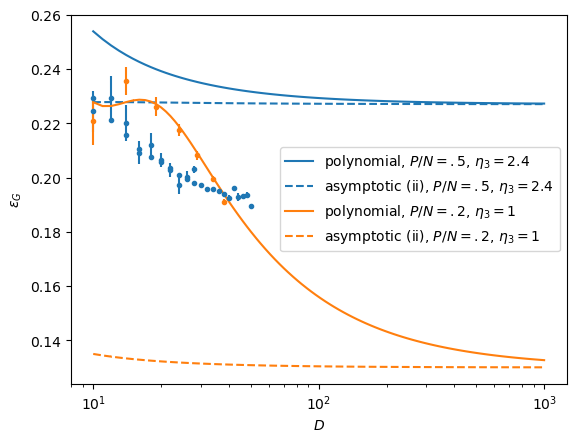

In [70]:
plt.plot(Ds,np.array(T1_varD_Egs),label=r"polynomial, $P/N=.5$, $\eta_3=2.4$",color="C0")
plt.plot(Ds,np.array(T1_varD_EgsAsII),'--',label=r"asymptotic (ii), $P/N=.5$, $\eta_3=2.4$",color="C0")
plt.errorbar(varD_DsNum,varD_EgsNum,yerr=varD_EgsNumErr,fmt='.',color="C0")
plt.errorbar(varD_DsNum_chow,varD_EgsNum_chow,yerr=varD_EgsNumErr_chow,fmt='.',color="C0")

plt.plot(Ds,np.array(T1_varD2_Egs),label=r"polynomial, $P/N=.2$, $\eta_3=1$",color="C1")
plt.plot(Ds,np.array(T1_varD2_EgsAsII),'--',label=r"asymptotic (ii), $P/N=.2$, $\eta_3=1$",color="C1")
plt.errorbar(varD2_DsNum,varD2_EgsNum,yerr=varD2_EgsNumErr,fmt='.',color="C1")
plt.xscale('log')
plt.xlabel(r'$D$')
plt.ylabel(r'$\epsilon_G$')
plt.legend()
plt.show()

# Classification task, linear teacher ($\theta^{(0)} = 0$), ReLU activation, 
# $D = 20$, $N = 2 \cdot 10^3$

In [120]:
C_T1_Th0_ReLU_Ps = np.logspace(0,4,100)
maxstep = 500

C_T1_Th0_ReLU_Egs = list()
C_T1_Th0_ReLU_EgsAsI1 = list()
C_T1_Th0_ReLU_EgsAsI2 = list()
C_T1_Th0_ReLU_EgsAsI3 = list()
C_T1_Th0_ReLU_EgsAsII = list()
C_T1_Th0_ReLU_q0s = list()
C_T1_Th0_ReLU_q1s = list()
C_T1_Th0_ReLU_q2s = list()
C_T1_Th0_ReLU_χ0s = list()
C_T1_Th0_ReLU_χ1s = list()
C_T1_Th0_ReLU_χ2s = list()
C_T1_Th0_ReLU_m0s = list()
C_T1_Th0_ReLU_m1s = list()
C_T1_Th0_ReLU_m2s = list()
for p in C_T1_Th0_ReLU_Ps:
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tStar = saddle(2*10**3,p,2,np.array([0,1,0,0]),maxstep,rate=.4,elu_relu=False,D=20)
    C_T1_Th0_ReLU_Egs.append(EgClas(mStar,qStar))
    C_T1_Th0_ReLU_q0s.append(q0)
    C_T1_Th0_ReLU_q1s.append(q[0])
    C_T1_Th0_ReLU_q2s.append(q[1])
    C_T1_Th0_ReLU_χ0s.append(χ0)
    C_T1_Th0_ReLU_χ1s.append(χ[0])
    C_T1_Th0_ReLU_χ2s.append(χ[1])
    C_T1_Th0_ReLU_m0s.append(m0)
    C_T1_Th0_ReLU_m1s.append(m[0])
    C_T1_Th0_ReLU_m2s.append(m[1])
    χStar,qStar,mStar,tStar = saddleAsymptI(p,1,np.array([0,1,0,0]),maxstep,rate=.4,elu_relu=False,D=20)[-4:]
    C_T1_Th0_ReLU_EgsAsI1.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptI(p,2,np.array([0,1,0,0]),maxstep,rate=.4,elu_relu=False,D=20)[-4:]
    C_T1_Th0_ReLU_EgsAsI2.append(EgClas(mStar,qStar))
    χStar,qStar,mStar,tStar = saddleAsymptII(2*10**3,p,2,np.array([0,1,0,0]),maxstep,rate=.4,elu_relu=False,D=20)[-4:]
    C_T1_Th0_ReLU_EgsAsII.append(EgClas(mStar,qStar))

In [121]:
C_T1_Th0_ReLU_PsNum = np.concatenate((np.loadtxt("data/tobmed.dat")[:,0].tolist(),np.loadtxt("data/tobmed2.dat")[:,0].tolist()))
C_T1_Th0_ReLU_EgsNum = np.concatenate((np.loadtxt("data/tobmed.dat")[:,1].tolist(),np.loadtxt("data/tobmed2.dat")[:,1].tolist()))

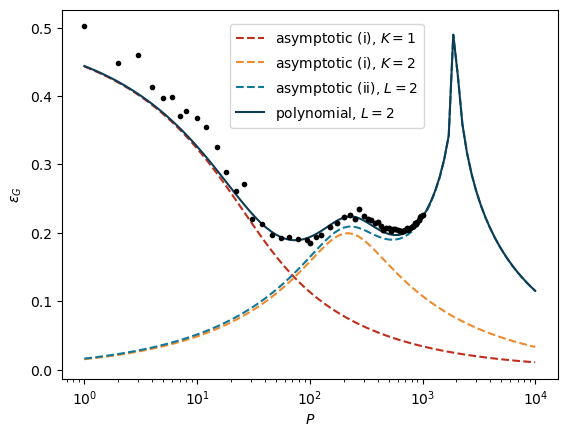

In [131]:
plt.plot(C_T1_Th0_ReLU_Ps,np.array(C_T1_Th0_ReLU_EgsAsI1),'--',label=r"asymptotic (i), $K = 1$",color=CC1)
plt.plot(C_T1_Th0_ReLU_Ps,np.array(C_T1_Th0_ReLU_EgsAsI2),'--',label=r"asymptotic (i), $K = 2$",color=CC2)
plt.plot(C_T1_Th0_ReLU_Ps,np.array(C_T1_Th0_ReLU_EgsAsII),'--',label=r"asymptotic (ii), $L = 2$",color=CC4)
plt.plot(C_T1_Th0_ReLU_Ps,np.array(C_T1_Th0_ReLU_Egs),label=r"polynomial, $L=2$",color=CC0)
plt.plot(C_T1_Th0_ReLU_PsNum,C_T1_Th0_ReLU_EgsNum,'.',color="black")
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$P$')
# plt.ylim((.15,.55))
plt.ylabel(r'$\epsilon_G$')
plt.legend(loc=(.34,.68))
plt.show()

# Regression task, quadratic teacher ($\theta^{(0)} = 0$), ReLU activation, 
# $D = 20$, $N = 2\cdot 10^3$

In [74]:
R_T1_Th0_Ps = np.logspace(0,4,100)
maxstep = 500

R_T1_Th0_Egs = list()
R_T1_Th0_EgsAsI1 = list()
R_T1_Th0_EgsAsI2 = list()
R_T1_Th0_EgsAsI3 = list()
R_T1_Th0_EgsAsII = list()
R_T1_Th0_q0s = list()
R_T1_Th0_q1s = list()
R_T1_Th0_q2s = list()
R_T1_Th0_χ0s = list()
R_T1_Th0_χ1s = list()
R_T1_Th0_χ2s = list()
R_T1_Th0_m0s = list()
R_T1_Th0_m1s = list()
R_T1_Th0_m2s = list()
for p in R_T1_Th0_Ps:
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tS = saddle(2*10**3,p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=0,yy=1,yν=1)
    R_T1_Th0_Egs.append(EgRegr(mStar,qStar,θ0=0,tStar=tS))
    R_T1_Th0_q0s.append(q0)
    R_T1_Th0_q1s.append(q[0])
    R_T1_Th0_q2s.append(q[1])
    R_T1_Th0_χ0s.append(χ0)
    R_T1_Th0_χ1s.append(χ[0])
    R_T1_Th0_χ2s.append(χ[1])
    R_T1_Th0_m0s.append(m0)
    R_T1_Th0_m1s.append(m[0])
    R_T1_Th0_m2s.append(m[1])
    χStar,qStar,mStar,tS = saddleAsymptI(p,1,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=0,yy=1,yν=1)[-4:]
    R_T1_Th0_EgsAsI1.append(EgRegr(mStar,qStar,θ0=0,tStar=tS))
    χStar,qStar,mStar,tS = saddleAsymptI(p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=0,yy=1,yν=1)[-4:]
    R_T1_Th0_EgsAsI2.append(EgRegr(mStar,qStar,θ0=0,tStar=tS))
    χStar,qStar,mStar,tS = saddleAsymptII(2*10**3,p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=0,yy=1,yν=1)[-4:]
    R_T1_Th0_EgsAsII.append(EgRegr(mStar,qStar,θ0=0,tStar=tS))

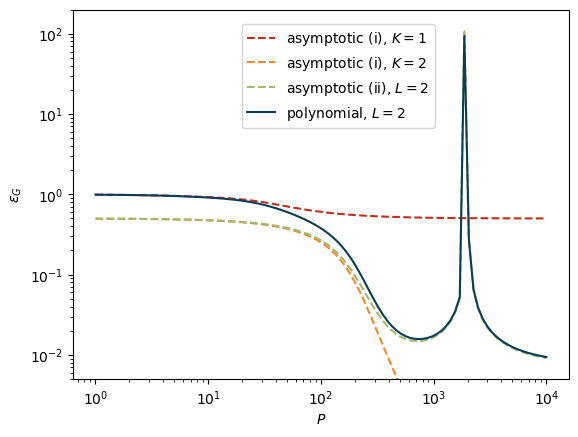

In [129]:
plt.plot(R_T1_Th0_Ps,np.array(R_T1_Th0_EgsAsI1),'--',label=r"asymptotic (i), $K = 1$",color=CC1)
plt.plot(R_T1_Th0_Ps,np.array(R_T1_Th0_EgsAsI2),'--',label=r"asymptotic (i), $K = 2$",color=CC2)
plt.plot(R_T1_Th0_Ps,np.array(R_T1_Th0_EgsAsII),'--',label=r"asymptotic (ii), $L = 2$",color=CC3)
plt.plot(R_T1_Th0_Ps,np.array(R_T1_Th0_Egs),label=r"polynomial, $L=2$",color=CC0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P$')
plt.ylim((5e-3,2e2))
plt.ylabel(r'$\epsilon_G$')
plt.legend(loc=(.34,.68))
plt.show()

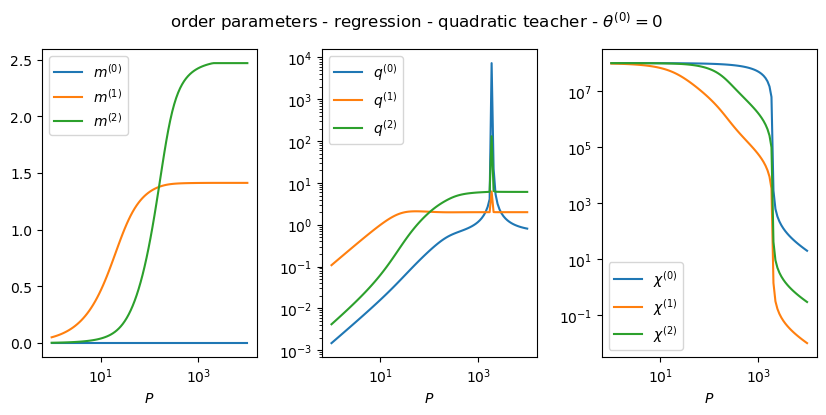

In [127]:
AT1fig,((AT1plM,AT1plQ,AT1plχ)) = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
plt.subplots_adjust(hspace=0,wspace=0.3)
AT1fig.suptitle(r"order parameters - regression - quadratic teacher - $θ^{(0)} = 0$" )
AT1plQ.plot(Ps,np.array(R_T1_Th0_q0s),label=r"$q^{(0)}$")
AT1plQ.plot(Ps,np.array(R_T1_Th0_q1s),label=r"$q^{(1)}$")
AT1plQ.plot(Ps,np.array(R_T1_Th0_q2s),label=r"$q^{(2)}$")
AT1plM.plot(Ps,np.array(R_T1_Th0_m0s),label=r"$m^{(0)}$")
AT1plM.plot(Ps,np.array(R_T1_Th0_m1s),label=r"$m^{(1)}$")
AT1plM.plot(Ps,np.array(R_T1_Th0_m2s),label=r"$m^{(2)}$")
AT1plχ.plot(Ps,np.array(R_T1_Th0_χ0s),label=r"$\chi^{(0)}$")
AT1plχ.plot(Ps,np.array(R_T1_Th0_χ1s),label=r"$\chi^{(1)}$")
AT1plχ.plot(Ps,np.array(R_T1_Th0_χ2s),label=r"$\chi^{(2)}$")
AT1plQ.set(xscale='log',yscale='log')
AT1plM.set(xscale='log')
AT1plχ.set(xscale='log',yscale='log')
AT1plχ.set_xlabel(r'$P$')
AT1plQ.set_xlabel(r'$P$')
AT1plM.set_xlabel(r'$P$')
AT1plQ.legend()
AT1plM.legend()
AT1plχ.legend()

# Regression task, quadratic teacher ($\theta^{(0)} = 1$), ReLU activation, 
# $D = 20$, $N = 2\cdot 10^3$

In [89]:
R_T1_Th1_Ps = np.logspace(0,4,100)
maxstep = 500

R_T1_Th1_Egs = list()
R_T1_Th1_EgsAsI1 = list()
R_T1_Th1_EgsAsI2 = list()
R_T1_Th1_EgsAsI3 = list()
R_T1_Th1_EgsAsII = list()
R_T1_Th1_q0s = list()
R_T1_Th1_q1s = list()
R_T1_Th1_q2s = list()
R_T1_Th1_χ0s = list()
R_T1_Th1_χ1s = list()
R_T1_Th1_χ2s = list()
R_T1_Th1_m0s = list()
R_T1_Th1_m1s = list()
R_T1_Th1_m2s = list()
for p in R_T1_Th1_Ps:
    hχ,hq,hm,hχ0,hq0,χ,q,m,χ0,q0,m0,χStar,qStar,mStar,tS = saddle(2*10**3,p,2,np.array([1,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=1,yy=2,yν=1)
    R_T1_Th1_Egs.append(EgRegr(mStar,qStar,θ0=1,tStar=tS))
    R_T1_Th1_q0s.append(q0)
    R_T1_Th1_q1s.append(q[0])
    R_T1_Th1_q2s.append(q[1])
    R_T1_Th1_χ0s.append(χ0)
    R_T1_Th1_χ1s.append(χ[0])
    R_T1_Th1_χ2s.append(χ[1])
    R_T1_Th1_m0s.append(m0)
    R_T1_Th1_m1s.append(m[0])
    R_T1_Th1_m2s.append(m[1])
    χStar,qStar,mStar,tS = saddleAsymptI(p,1,np.array([1,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=1,yy=2,yν=1)[-4:]
    R_T1_Th1_EgsAsI1.append(EgRegr(mStar,qStar,θ0=1,tStar=tS))
    χStar,qStar,mStar,tS = saddleAsymptI(p,2,np.array([1,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=1,yy=2,yν=1)[-4:]
    R_T1_Th1_EgsAsI2.append(EgRegr(mStar,qStar,θ0=1,tStar=tS))
    χStar,qStar,mStar,tS = saddleAsymptII(2*10**3,p,2,np.array([1,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep,rate=.4,elu_relu=False,D=20,y=1,yy=2,yν=1)[-4:]
    R_T1_Th1_EgsAsII.append(EgRegr(mStar,qStar,θ0=1,tStar=tS))

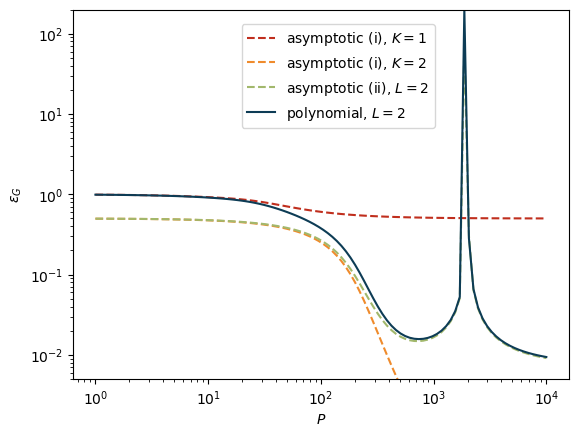

In [133]:
plt.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_EgsAsI1),'--',label=r"asymptotic (i), $K = 1$",color=CC1)
plt.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_EgsAsI2),'--',label=r"asymptotic (i), $K = 2$",color=CC2)
plt.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_EgsAsII),'--',label=r"asymptotic (ii), $L = 2$",color=CC3)
plt.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_Egs),label=r"polynomial, $L=2$",color=CC0)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$P$')
plt.ylim((5e-3,2e2))
plt.ylabel(r'$\epsilon_G$')
plt.legend(loc=(.34,.68))
plt.show()

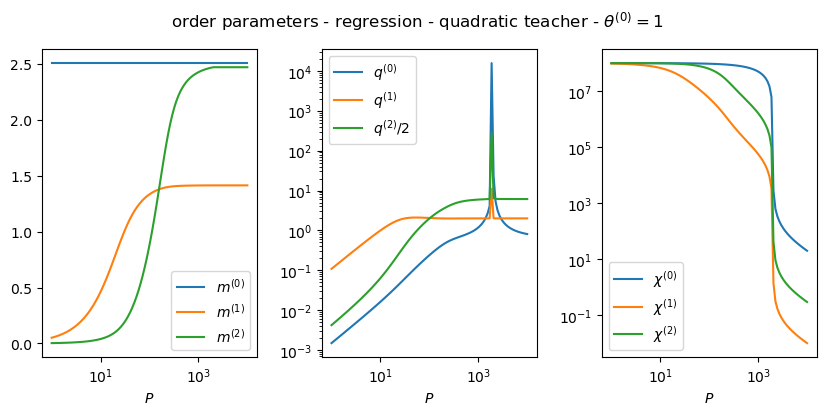

In [130]:
AT1fig,((AT1plM,AT1plQ,AT1plχ)) = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
plt.subplots_adjust(hspace=0,wspace=.3)
AT1fig.suptitle(r"order parameters - regression - quadratic teacher - $\theta^{(0)}=1$" )
AT1plQ.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_q0s),label=r"$q^{(0)}$")
AT1plQ.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_q1s),label=r"$q^{(1)}$")
AT1plQ.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_q2s),label=r"$q^{(2)}/2$")
AT1plM.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_m0s),label=r"$m^{(0)}$")
AT1plM.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_m1s),label=r"$m^{(1)}$")
AT1plM.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_m2s),label=r"$m^{(2)}$")
AT1plχ.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_χ0s),label=r"$\chi^{(0)}$")
AT1plχ.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_χ1s),label=r"$\chi^{(1)}$")
AT1plχ.plot(R_T1_Th1_Ps,np.array(R_T1_Th1_χ2s),label=r"$\chi^{(2)}$")
AT1plQ.set(xscale='log',yscale='log')
AT1plM.set(xscale='log')
AT1plχ.set(xscale='log',yscale='log')
AT1plχ.set_xlabel(r'$P$')
AT1plQ.set_xlabel(r'$P$')
AT1plM.set_xlabel(r'$P$')
AT1plQ.legend()
AT1plM.legend()
AT1plχ.legend()